# Convolutional Neural Network from Scratch
---
This is part of a broader project for LiDAR point segmentation.




The goal of this section will be to engineer a CNN from scratch both for the purposes of LiDAR point cloud segmentation and as a learning experience.

The architecture of the neural network will be built keeping in mind the end purpose, as such, I will try to implement only what is necessary.

I will implement a basic neural network first for the sake of clarity and then implement the CNN specific layers after.

In [ ]:
import numpy as np  # Python doesn't have vectors natively
import math

# Core Neural Network Architecture
---

In [ ]:
class Layer:
  def __init__(self):
    pass
  def forward(self, x):
    raise NotImplementedError
  def backward(self, output_gradient):
    raise NotImplementedError

I'll implement the ReLU function as it is the most commonly used and standard neural network activation function.

The formula for this simple: if the input is less than 0 then return 0, if it is greater than or equal to 0 then return the input:

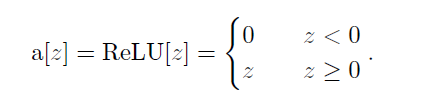

This also (mostly) describes its derivative for the backward pass as well

In [ ]:
class ReLU(Layer):
  def __init__(self):
    super().__init__()
  def forward(self, preactivation):
    self.input = preactivation
    return np.maximum(0.0, preactivation)
  def backward(self, output_gradient):
    return output_gradient * (self.input > 0)

Let's now implement the Linear layer first as it is more general purpose and the backbone of neural networks in general



The formula for any hidden unit (neuron) is the standard linear function, albeit vectorized instead of summed

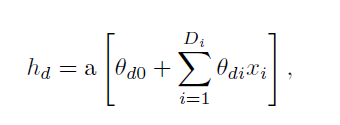

with the final output for the forward pass taking a similar form (without the activation)

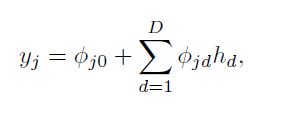

The backward passes must be calculated with respect to the biases and weight separately. The derivative of the loss with respect to the bias is just equal to the derivative of the loss with respect to the network output:

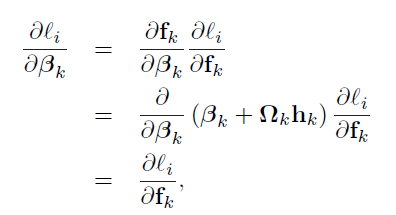

And the derivative of the loss with respect to the weights is the derivative of the loss with respect to the network output times the input transposed

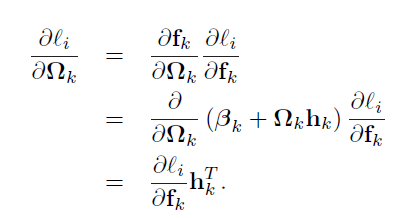

We will implement L2 regularization in the linear backward pass only, as that is only what is needed to affect model weights:

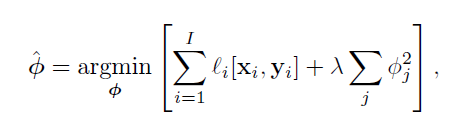

In [ ]:
class Linear(Layer):
  def __init__(self, neurons: int):
    super().__init__()
    self.neurons = neurons
    self.weights = None
    self.biases = None
    self.input = None
    self.m_weights, self.m_biases = 0, 0 # Initialization for momentum
    self.v_weights, self.v_biases = 0, 0 # Initialization for squared gradients

  def forward(self, x):
    if self.weights is None:
      input_dim = x.shape[1]
      self.biases = np.zeros((1, self.neurons))
      self.weights = np.random.randn(input_dim, self.neurons) * np.sqrt(2 / input_dim)  # He initialization

    self.input = x
    self.preactivation = (self.input @ self.weights) + self.biases

    return self.preactivation

  def backward(self, output_gradient, lambda_):
    preactivation_gradient = output_gradient

    # Gradient of loss w.r.t. biases
    self.dl_db = np.sum(preactivation_gradient, axis=0, keepdims=True)
    # Gradient of loss w.r.t. weights
    self.dl_dw = self.input.T @ preactivation_gradient + lambda_ * 2 * self.weights # Derivative of phi**2 is 2 * phi and
    # Gradient to pass to the previous layer                                        # the loss is already calculated for us here
    input_gradient = preactivation_gradient @ self.weights.T

    return input_gradient

We have our core layer constructed, we can move onto the loss function. We will use a multi-class cross entropy loss because a segmentation task is really just a multi-class classification task.

The formula for the softmax function:

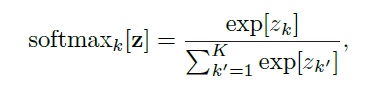

And the loss itself is given by:

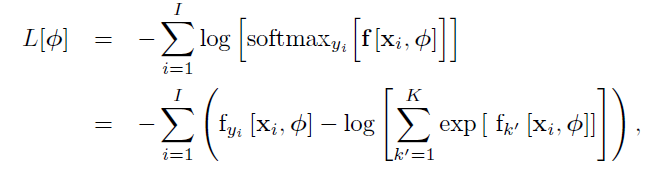

The backward pass is just defined by the predictions - actuals / total samples (in this case pixels)

Implementing the L2 regularized loss here would make it clearer during training but it isn't necessary

In [ ]:
class MultiClassCrossEntropyLoss():
  def __init__(self):
    pass

  def softmax(self, model_out):
    stable_out = model_out - np.max(model_out, axis=1, keepdims=True)
    exp_out = np.exp(stable_out)
    return exp_out / np.sum(exp_out, axis=1, keepdims=True)

  def forward(self, y_pred, y_actual):
    sample_count = y_actual.size
    probs = self.softmax(y_pred)
    actual_probs = probs[np.arange(sample_count), y_actual.flatten()]

    loss = np.mean(-np.log(actual_probs + 1e-15))

    return loss

  def backward(self, y_pred, y_actual):
    sample_count = y_actual.size
    probs = self.softmax(y_pred)
    one_hot_actuals = np.zeros_like(y_pred)
    one_hot_actuals[np.arange(sample_count), y_actual.flatten()] = 1
    output_gradient = (probs - one_hot_actuals) / sample_count
    return output_gradient

In [ ]:
class Dropout(Layer):
  def __init__(self, dropout_rate):
    super().__init__()
    self.dropout_rate = dropout_rate
    self.mask = None
    self.training = True

  # Create a random mask to overlay our layer and save it
  def forward(self, x):
    if self.training:
      self.mask = (np.random.rand(*x.shape) > self.dropout_rate)
      return (x * self.mask) / (1.0 - self.dropout_rate)
    else:
      return x

  def backward(self, output_gradient):
    return (output_gradient * self.mask) / (1.0 - self.dropout_rate)

Just to make everything more organized and cleaner, we'll implement a Sequential class as a container for the layers that can call the forward and backward methods of each layer for us:

In [ ]:
class Sequential(Layer):
  def __init__(self, layers: list):
    self.layers = layers

  def forward(self, x):
    output = x
    for layer in self.layers:
      output = layer.forward(output)
    return output

  def backward(self, output_gradient, lambda_):
    grad = output_gradient
    for layer in self.layers[::-1]:
      if hasattr(layer, 'weights'):
        grad = layer.backward(grad, lambda_)
      else:
        grad = layer.backward(grad)
    return grad

  def set_training_mode(self, training: bool):
    """Sets the training mode for all layers in the model."""
    for layer in self.layers:
      if hasattr(layer, 'training'):
        layer.training = training

And also just for a bit more robustness in training, let's add an optimizer. Adam is the most common one and it works well enough in most cases.

First, the optimizer needs the momentum for the gradients defined by:

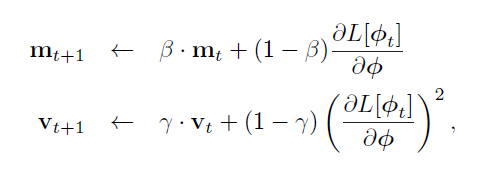

where the momentum is a moving, weighted combination of the current gradient and the direction moved so far. This is for the weights

For the biases:

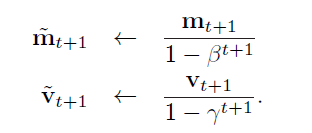

And the final parameter update step is defined by:

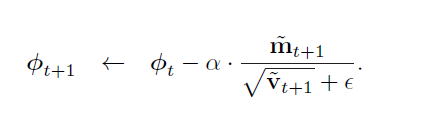

In [ ]:
class Adam():
    def __init__(self, lr, beta, gamma, eps=1e-8):
        self.learning_rate = lr
        self.beta = beta
        self.gamma = gamma
        self.eps = eps
        self.t = 0

    def _ensure_moments(self, layer):
        # Initialize moments if missing or not arrays
        if not isinstance(getattr(layer, 'm_weights', None), np.ndarray):
            layer.m_weights = np.zeros_like(layer.weights, dtype=np.float32)
        if not isinstance(getattr(layer, 'v_weights', None), np.ndarray):
            layer.v_weights = np.zeros_like(layer.weights, dtype=np.float32)
        if not isinstance(getattr(layer, 'm_biases', None), np.ndarray):
            layer.m_biases  = np.zeros_like(layer.biases,  dtype=np.float32)
        if not isinstance(getattr(layer, 'v_biases', None), np.ndarray):
            layer.v_biases  = np.zeros_like(layer.biases,  dtype=np.float32)

    def step(self, model):
        self.t += 1
        for layer in model.layers:
            if not hasattr(layer, 'weights'):
                continue
            dl_dw = getattr(layer, 'dl_dw', getattr(layer, 'dW', None))
            dl_db = getattr(layer, 'dl_db', getattr(layer, 'db', None))
            if dl_dw is None or dl_db is None:
                continue

            self._ensure_moments(layer)

            # Weights
            layer.m_weights = self.beta * layer.m_weights + (1 - self.beta) * dl_dw
            layer.v_weights = self.gamma * layer.v_weights + (1 - self.gamma) * (dl_dw ** 2)
            m_w_hat = layer.m_weights / (1 - self.beta ** self.t)
            v_w_hat = layer.v_weights / (1 - self.gamma ** self.t)
            layer.weights = layer.weights - self.learning_rate * (m_w_hat / (np.sqrt(v_w_hat) + self.eps))

            # Biases
            layer.m_biases = self.beta * layer.m_biases + (1 - self.beta) * dl_db
            layer.v_biases = self.gamma * layer.v_biases + (1 - self.gamma) * (dl_db ** 2)
            m_b_hat = layer.m_biases / (1 - self.beta ** self.t)
            v_b_hat = layer.v_biases / (1 - self.gamma ** self.t)
            layer.biases = layer.biases - self.learning_rate * (m_b_hat / (np.sqrt(v_b_hat) + self.eps))


Again like with the Sequential class, let's create a training function to handle the training process in a clear and organized manner.

In [ ]:
import copy

def train(x_train,
          y_train,
          loss_func,
          model: Sequential,
          optimizer,
          epochs: int,
          loss_check: int,
          lambda_=0.0,
          x_val=None,
          y_val=None,
          patience=10,
          training_mode=True):

  best_val_loss = float('inf')
  patience_counter = 0
  best_model_state = None

  for epoch in range(epochs):
    preds = model.forward(x_train)
    loss = loss_func.forward(preds, y_train)
    model.backward(loss_func.backward(preds, y_train), lambda_)
    optimizer.step(model)

    model.set_training_mode(False)
    val_preds = model.forward(x_val)
    val_loss = loss_func.forward(val_preds, y_val)

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      patience_counter = 0
      best_model_state = copy.deepcopy(model.layers)
    else:
      patience_counter += 1

    if patience_counter >= patience:
      print(f"\n--- Early stopping triggered at epoch {epoch} ---")
      model.layers = best_model_state
      break

    if epoch % loss_check == 0:
      print(f'Epoch {epoch} | Training Loss: {loss:.4f} | Validation Loss: {val_loss:.4f}')
    model.set_training_mode(True)

  return model # Return the best performing model

Alright! This should work, let's test on an extremely basic data set.

# Testing a Basic Model
---

In [ ]:
#!pip install mnist1d

In [ ]:
import mnist1d

args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=True)

# Extract the arrays from the data dictionary and format them.
X_train = data['x']
y_train = data['y']
X_test = data['x_test']
y_test = data['y_test']

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Added afterwards for early stopping
val_split_index = 3500

x_val = X_train[val_split_index:, :]
y_val = y_train[val_split_index:]
x_train_split = X_train[:val_split_index, :]
y_train_split = y_train[:val_split_index]

print(f"New training data shape: {x_train_split.shape}")
print(f"Validation data shape: {x_val.shape}")

Saving to ./mnist1d_data.pkl
Successfully loaded data from ./mnist1d_data.pkl
Training data shape: (4000, 40)
Testing data shape: (1000, 40)
New training data shape: (3500, 40)
Validation data shape: (500, 40)


In [ ]:
model = Sequential([
    Linear(neurons=128),
    ReLU(),
    Linear(neurons=128),
    ReLU(),
    Linear(neurons=64),
    ReLU(),
    Linear(neurons=10) # 10 output neurons for 10 digits
])

optimizer = Adam(lr=0.01, beta=0.9, gamma=0.999)
loss_func = MultiClassCrossEntropyLoss()

train(x_train=x_train_split,
      y_train=y_train_split,
      loss_func=loss_func,
      model=model,
      optimizer=optimizer,
      epochs=201,
      loss_check=20,
      lambda_ = 0.001,
      x_val = x_val,
      y_val = y_val,
      patience = 20) # Print loss every 20 epochs



# Check accuracy on the training data
train_preds = model.forward(x_train_split)
train_predicted_labels = np.argmax(train_preds, axis=1)
train_accuracy = np.mean(train_predicted_labels == y_train_split)
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Check accuracy on the testing data
test_preds = model.forward(X_test)
test_predicted_labels = np.argmax(test_preds, axis=1)
test_accuracy = np.mean(test_predicted_labels == y_test)
print(f"Final Testing Accuracy: {test_accuracy * 100:.2f}%")

Epoch 0 | Training Loss: 2.8176 | Validation Loss: 2.7820
Epoch 20 | Training Loss: 1.4060 | Validation Loss: 1.4498
Epoch 40 | Training Loss: 0.9151 | Validation Loss: 1.1541
Epoch 60 | Training Loss: 0.5578 | Validation Loss: 1.0741
Epoch 80 | Training Loss: 0.3146 | Validation Loss: 1.1608

--- Early stopping triggered at epoch 81 ---
Final Training Accuracy: 82.31%
Final Testing Accuracy: 62.00%


Very clearly overfitting, however, the point was just to get a working demo going. In this case the model architecture is a success. Let's move on to improving the model.

Let's go back and implement some regularization

Note: I ran the demo a few times, the final output might not be indicative of the regularization improvements or base performance

# Regularization
---

This section is just added as a flag to signal that I implemented some regularization methods.

Accuracy on the test set improved by about 2-6% with the same model with L2 regularization.

Early stopping and implementing a Dropout layer minimally affected accuracy on test set, but this is fine since we don't have much data and we cut up the little data we had into 3 sections.

All in all, the regularization techniques had a measurable but small impact, the improvements can likely be exacerbated with more data or a different model architecture.

We can move onto the CNN specific layers now.

# Convolutional Layers
---

Here we will implement the main layers of a convolutional network.

I will skip implementing a 1D convolutional layer because it wouldn't be useful on anything in this project other than showing the difference between the covolutional network and regular fully connected network.

We, as of yet, still need the convolutional, pooling and flattening layers.

Let's do the flatten layer first as it is the simplest.

This will let us feed the convolutional output into a linear layer for the final predictions


In [ ]:
class Flatten(Layer):
  def __init__(self):
    self.original_shape = None

  def forward(self, x):

    '''Forward pass is just the flatten itself'''

    self.original_shape = x.shape

    # Leaves batch size alone, assumes input is in the form
    # (batch_size, channels, pixels_y, pixels_x)
    batch_size = x.shape[0]
    features = np.prod(x.shape[1:])
    flattened = np.reshape(x, (batch_size, features))

    return flattened

  def backward(self, output_gradient):
    return np.reshape(output_gradient, self.original_shape)

Next we will need a way to convert images into a format compatible with our NNs.

The im2col and col2im functions are well known and would benefit from vectorization.

Using for loops here would make the implementations simpler but would also drastically increase computation time. Vectorizing also lets us experiment with CUDA acceleration, which will be implemented later.

In [ ]:
def im2col(x, kernel_size, stride=1, padding=0):
    """
    Fully vectorized im2col using stride_tricks.
    """
    N, C, H, W = x.shape
    kh, kw = kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride
    ph, pw = (padding, padding) if isinstance(padding, int) else padding

    out_h = (H + 2 * ph - kh) // sh + 1
    out_w = (W + 2 * pw - kw) // sw + 1

    # Pad and build sliding windows
    x_padded = np.pad(x, ((0, 0), (0, 0), (ph, ph), (pw, pw)), mode='constant')
    view_shape = (N, C, out_h, out_w, kh, kw)
    view_strides = (
        x_padded.strides[0],  # N stride
        x_padded.strides[1],  # C stride
        x_padded.strides[2] * sh,  # out_h stride
        x_padded.strides[3] * sw,  # out_w stride
        x_padded.strides[2],  # kh stride
        x_padded.strides[3]   # kw stride
    )
    patches = np.lib.stride_tricks.as_strided(
        x_padded, view_shape, view_strides, writeable=False
    )
    cols = patches.transpose(1, 4, 5, 0, 2, 3).reshape(C * kh * kw, N * out_h * out_w)
    return cols.astype(np.float32, copy=False)

And we will need the reciprocal col2im function for our backward pass.

In [ ]:
def col2im(cols, x_shape, kernel_size, stride=1, padding=0):
    """
    Fully vectorized col2im implementation using advanced numpy indexing.
    """
    N, C, H, W = x_shape
    kh, kw = kernel_size
    sh, sw = (stride, stride) if isinstance(stride, int) else stride
    ph, pw = (padding, padding) if isinstance(padding, int) else padding

    H_padded, W_padded = H + 2 * ph, W + 2 * pw
    x_padded = np.zeros((N, C, H_padded, W_padded), dtype=np.float32)

    out_h = (H + 2 * ph - kh) // sh + 1
    out_w = (W + 2 * pw - kw) // sw + 1

    cols_reshaped = cols.reshape(C, kh, kw, N, out_h, out_w)

    # Build indices
    n_idx, c_idx, oh_idx, ow_idx, kh_idx, kw_idx = np.meshgrid(
        np.arange(N), np.arange(C), np.arange(out_h), np.arange(out_w),
        np.arange(kh), np.arange(kw), indexing='ij'
    )
    y_idx = oh_idx * sh + kh_idx
    x_idx = ow_idx * sw + kw_idx

    n_flat = n_idx.flatten()
    c_flat = c_idx.flatten()
    y_flat = y_idx.flatten()
    x_flat = x_idx.flatten()

    values = cols_reshaped[c_flat, kh_idx.flatten(), kw_idx.flatten(),
                           n_flat, oh_idx.flatten(), ow_idx.flatten()]

    np.add.at(x_padded, (n_flat, c_flat, y_flat, x_flat), values)

    if padding == 0:
        return x_padded
    return x_padded[:, :, ph:-ph, pw:-pw]


The equation for a single channel 2D convolution is as follows:

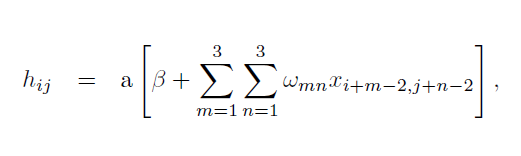

However we need to make some modifications to it for practical purposes, namely allowing for variable inputs and generating the indices ahead of time (which we did in the im2col functions).

Here's a diagram to show a basic idea of how the 2D convolution works and also to make it clearer on why we need to generate the indices in advance for vectorization:

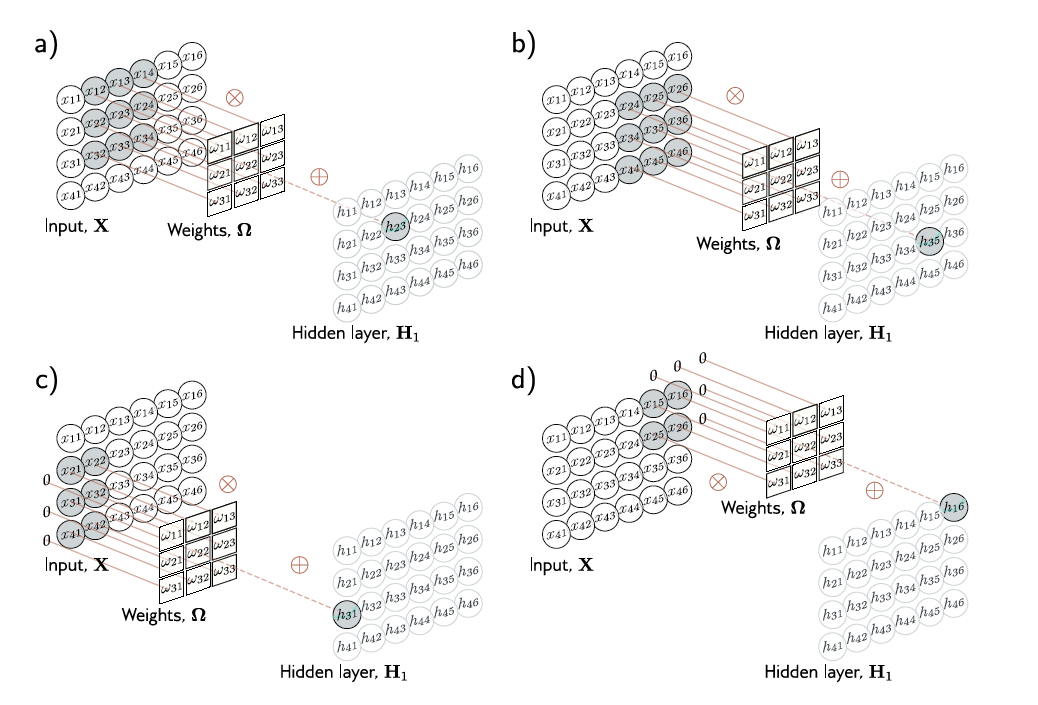

In [ ]:
class Conv2D(Layer):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, dilation=1, padding=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size if isinstance(kernel_size, tuple) else (kernel_size, kernel_size)
        self.stride = stride
        self.dilation = dilation  # Note: not applied in this im2col version
        self.padding = padding

        fan_in = self.in_channels * self.kernel_size[0] * self.kernel_size[1]
        kernel_shape = (self.out_channels, self.in_channels, self.kernel_size[0], self.kernel_size[1])
        self.weights = np.random.randn(*kernel_shape) * np.float32(np.sqrt(2.0 / fan_in))
        self.biases = np.zeros((self.out_channels,), dtype=np.float32)

        self.m_weights, self.m_biases = np.zeros_like(self.weights), np.zeros_like(self.biases)
        self.v_weights, self.v_biases = np.zeros_like(self.weights), np.zeros_like(self.biases)

    def forward(self, x):
        self.input_shape = x.shape
        N, C, H, W = x.shape

        self.out_h = (H - self.kernel_size[0] + 2 * self.padding) // self.stride + 1
        self.out_w = (W - self.kernel_size[1] + 2 * self.padding) // self.stride + 1

        # im2col in float32
        self.cols = im2col(x.astype(np.float32, copy=False), self.kernel_size, self.stride, self.padding)
        weights_flat = self.weights.reshape(self.out_channels, -1)
        out = weights_flat @ self.cols + self.biases.reshape(-1, 1)
        out = out.reshape(self.out_channels, N, self.out_h, self.out_w)
        return out.transpose(1, 0, 2, 3)

    def backward(self, dy, lambda_=0):
        N, C, H, W = self.input_shape

        # Gradients
        self.db = np.sum(dy, axis=(0, 2, 3)).astype(np.float32, copy=False)
        dy_flat = dy.transpose(1, 2, 3, 0).reshape(self.out_channels, -1).astype(np.float32, copy=False)
        self.dW = (dy_flat @ self.cols.T).reshape(self.weights.shape).astype(np.float32, copy=False)
        self.dW += np.float32(2.0 * lambda_) * self.weights

        # Input grad via col2im
        W_flat = self.weights.reshape(self.out_channels, -1)
        dx_col = W_flat.T @ dy_flat
        dx = col2im(dx_col, self.input_shape, self.kernel_size, self.stride, self.padding)
        return dx

As is typical for CNNs, we should also implement a pooling layer.

Max pooling would be favorable for the purpose of LiDAR segmentation as it reduces computational cost (for better efficiency in constrained vehicle systems) and lets the model generalize better in a complex scene.

A max pooling implementation is relatively simple, all we need to do is get the max value of each patch (im2col coming in handy again) for the forward pass and place it back in the original position for the backward.

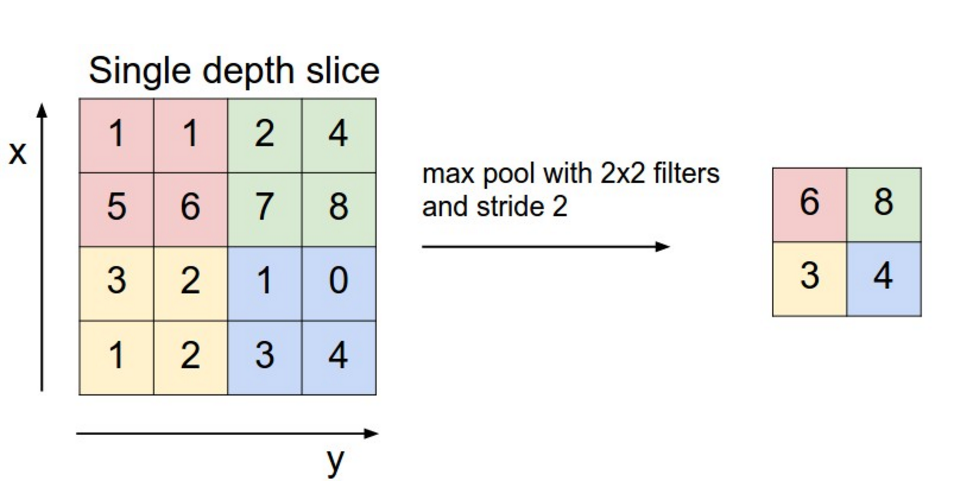

In [ ]:
class MaxPool2D(Layer):
    def __init__(self, pool_size, stride):
        super().__init__()
        self.pool_size = pool_size if isinstance(pool_size, tuple) else (pool_size, pool_size)
        self.stride = stride
        self.input_shape = None
        self.cache = {}

    def forward(self, x):
        self.input_shape = x.shape
        N, C, H, W = x.shape
        kh, kw = self.pool_size
        sh, sw = (self.stride, self.stride) if isinstance(self.stride, int) else self.stride

        out_h = (H - kh) // sh + 1
        out_w = (W - kw) // sw + 1

        cols = im2col(x, self.pool_size, self.stride, padding=0)
        cols = cols.reshape(C, kh * kw, N, out_h, out_w)

        max_indices = np.argmax(cols, axis=1)
        max_vals = np.max(cols, axis=1)

        self.cache['max_indices'] = max_indices
        self.cache['cols_shape'] = cols.shape

        output = max_vals.transpose(1, 0, 2, 3)  # (N, C, out_h, out_w)
        return output

    def backward(self, output_gradient):
        C, kh_kw, N, out_h, out_w = self.cache['cols_shape']
        kh = kw = int(np.sqrt(kh_kw))

        dx_col = np.zeros(self.cache['cols_shape'], dtype=np.float32)
        flat_grad = output_gradient.transpose(1, 0, 2, 3).flatten()
        max_indices_flat = self.cache['max_indices'].flatten()

        c_coords = np.repeat(np.arange(C), N * out_h * out_w)
        n_coords = np.tile(np.repeat(np.arange(N), out_h * out_w), C)
        oh_coords = np.tile(np.repeat(np.arange(out_h), out_w), C * N)
        ow_coords = np.tile(np.arange(out_w), C * N * out_h)

        dx_col[c_coords, max_indices_flat, n_coords, oh_coords, ow_coords] = flat_grad
        dx_col = dx_col.reshape(C * kh * kw, N * out_h * out_w)
        dx = col2im(dx_col, self.input_shape, self.pool_size, self.stride, padding=0)
        return dx

# CNN Testing
---

Alright looks like everything is complete let's now testy the CNN architecture.

In [ ]:
#!pip install tensorflow

In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, y_train_m), (x_test, y_test_m) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=1).astype(np.float32, copy=False)
x_test = np.expand_dims(x_test, axis=1).astype(np.float32, copy=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
import time

def train_cnn_with_batches(x_train, y_train, model, loss_func, optimizer, epochs, batch_size, lambda_=0.0):
    """
    Mini-batch training with shuffling and per-epoch logging.
    """
    num_samples = x_train.shape[0] # Correctly get the number of samples from the first dimension

    for epoch in range(epochs):
        epoch_start_time = time.time()

        # Shuffle
        permutation = np.random.permutation(num_samples)
        x_train_shuffled = x_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_loss = 0.0
        num_batches = 0

        for i in range(0, num_samples, batch_size):
            try:
                end_idx = min(i + batch_size, num_samples)
                x_batch = x_train_shuffled[i:end_idx]
                y_batch = y_train_shuffled[i:end_idx]

                model.set_training_mode(True)

                preds = model.forward(x_batch)
                loss = loss_func.forward(preds, y_batch)
                grad = loss_func.backward(preds, y_batch)

                model.backward(grad, lambda_)
                optimizer.step(model)

                epoch_loss += loss
                num_batches += 1

            except Exception as e:
                print(f"Error in batch {i//batch_size}: {e}")
                continue

        if num_batches > 0:
            avg_loss = epoch_loss / num_batches
            epoch_end_time = time.time()
            print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f} | Time: {epoch_end_time - epoch_start_time:.2f}s")

    return model

In [ ]:
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

cnn_model = Sequential([
    Conv2D(in_channels=1, out_channels=6, kernel_size=5, padding=2),
    ReLU(),
    MaxPool2D(pool_size=2, stride=2),
    Conv2D(in_channels=6, out_channels=16, kernel_size=5),
    ReLU(),
    MaxPool2D(pool_size=2, stride=2),
    Flatten(),
    Linear(neurons=120),
    ReLU(),
    Linear(neurons=84),
    ReLU(),
    Linear(neurons=10)
])

cnn_optimizer = Adam(lr=0.001, beta=0.9, gamma=0.999, eps=1e-8)
cnn_loss = MultiClassCrossEntropyLoss()

print("\nStarting model training...")
trained_model = train_cnn_with_batches(
    x_train=x_train,
    y_train=y_train_m,
    model=cnn_model,
    loss_func=cnn_loss,
    optimizer=cnn_optimizer,
    epochs=1,
    batch_size=3072,
    lambda_=0.001
)

print("\nEvaluating model on test data...")
test_preds = trained_model.forward(x_test)
test_predicted_labels = np.argmax(test_preds, axis=1)
test_accuracy = np.mean(test_predicted_labels == y_test_m)
print(f"Final Test Accuracy: {test_accuracy * 100:.2f}%")

Training data shape: (60000, 1, 28, 28)
Test data shape: (10000, 1, 28, 28)

Starting model training...
Epoch 1/1 | Loss: 1.5777 | Time: 646.56s

Evaluating model on test data...
Final Test Accuracy: 80.58%


This was just a demo to see if the CNN worked, and it is a success!

Let's move on

Obviously this isn't a great score, I just set the lamba value really high to speed up training.

# Upsampling
---
For segmentation tasks specifically, we will want to utilize an encoder-decoder architecture.

The parts used for classification can also be used for the encoder portion of our architecture.

For the decoder portion, we will need to implement an upsampling method.

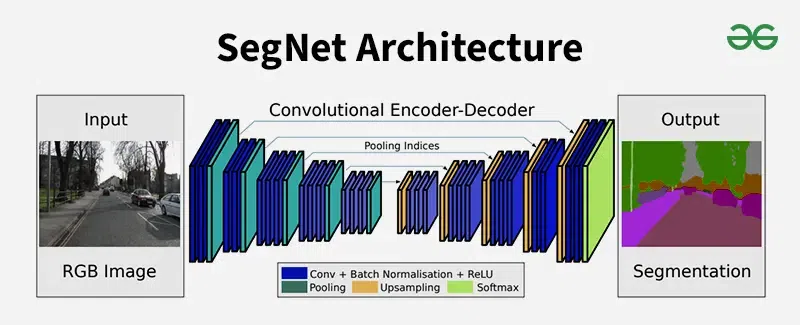

Here is a graphic of a typical encoder-decoder architecture.

In [ ]:
class Upsample(Layer):
  def __init__(self, scale_factor):
    self.scale_factor = scale_factor

  def forward(self, x):
    self.input_shape = x.shape
    upsampled_h = np.repeat(x, self.scale_factor, axis=2)
    output = np.repeat(upsampled_h, self.scale_factor, axis=3)
    return output

  def backward(self, output_gradient):
    N, C, H, W = self.input_shape
    sf = self.scale_factor
    reshaped_grad = output_gradient.reshape(N, C, H, sf, W, sf)
    input_gradient = reshaped_grad.sum(axis=5).sum(axis=3)
    return input_gradient

# Moving On
---
Ok looks like our CNN works, let's move onto the LiDAR specific portions, we will do this in a separate notebook.